In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
import tensorflow as tf

# Load the model for fibrosis
fibrosis_model = tf.keras.models.load_model("D:/PATENT/Model_testing/fibrosis_modified_model25.h5")



In [ ]:
# Function to calculate the area of dark blue stain on the original image
def calculate_blue_area_original(img_path):
    img = load_img(img_path, target_size=(299, 299))
    img_array = img_to_array(img) / 255.0
    
    # Convert image to HSV color space to isolate the blue stain
    hsv = cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV)
    
    # Define lower and upper bounds for dark blue color in HSV
    lower_dark_blue = np.array([90, 50, 50])
    upper_dark_blue = np.array([130, 255, 100])
    
    # Threshold the HSV image to get only dark blue colors
    mask = cv2.inRange(hsv, lower_dark_blue, upper_dark_blue)
    
    # Calculate the area of blue stain
    blue_area_original = np.sum(mask > 0)  # Count non-zero pixels in the mask
    return blue_area_original, mask

# Function to generate feature maps from the model and visualize the areas of focus
def generate_feature_map_fibrosis(img_path, model, last_conv_layer_name='conv5_block3_3_conv'):
    img = load_img(img_path, target_size=(299, 299))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    
    # Get the last convolutional layer
    feature_model = Model(inputs=model.input, outputs=model.get_layer(last_conv_layer_name).output)
    print(feature_model)
    feature_maps = feature_model.predict(img_array)[0]
    
    return feature_maps

# Function to calculate the blue stain area from feature maps
def calculate_blue_area_from_feature_maps(feature_maps):
    # Apply threshold to identify regions of focus (based on intensity)
    threshold_value = np.max(feature_maps) * 0.5  # Use 50% of the max intensity as threshold
    focus_mask = np.sum(feature_maps > threshold_value, axis=-1)  # Sum along the channel dimension
    
    # Count non-zero pixels (regions of focus)
    blue_area_model = np.sum(focus_mask > 0)
    return blue_area_model, focus_mask

# Function to visualize feature maps and original mask
def visualize_blue_areas(original_image, original_mask, focus_mask):
    # Plot the original image
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image')

    # Plot the original blue area mask
    plt.subplot(1, 3, 2)
    plt.imshow(original_mask, cmap='Blues')
    plt.title('Blue Area - Original')

    # Plot the model-extracted blue area mask
    plt.subplot(1, 3, 3)
    plt.imshow(focus_mask, cmap='hot')
    plt.title('Blue Area - Model Focus')
    plt.show()

# Path to the input image
img_path = "D:/PATENT/random_test_images/Fibrosis/f_2_400_62_22.jpg"

# Step 1: Calculate blue area from the original image
blue_area_original, original_mask = calculate_blue_area_original(img_path)

# Step 2: Generate feature maps from the fibrosis model
feature_maps = generate_feature_map_fibrosis(img_path, fibrosis_model)

# Step 3: Calculate blue area from the model's focus regions (feature maps)
blue_area_model, focus_mask = calculate_blue_area_from_feature_maps(feature_maps)

# Visualize the results
visualize_blue_areas(load_img(img_path, target_size=(299, 299)), original_mask, focus_mask)

# Print out the calculated areas
print(f"Blue Stain Area (Original Image): {blue_area_original} pixels")
print(f"Blue Stain Area (Model-Extracted): {blue_area_model} pixels")


In [ ]:
for layer in fibrosis_model.layers:
    print(layer.name)

In [ ]:
#calculating area in %

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
import tensorflow as tf
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu

# Load the fibrosis model
fibrosis_model = tf.keras.models.load_model("D:/PATENT/Model_testing/fibrosis_modified_model25.h5")

# Function to calculate the blue stain area using Otsu's thresholding on the original image
def calculate_blue_area_original_otsu(img_path):
    img = load_img(img_path, target_size=(299, 299))
    img_array = img_to_array(img) / 255.0
    
    # Convert image to grayscale
    gray = rgb2gray(img_array)
    
    # Apply Otsu's thresholding
    thresh_val = threshold_otsu(gray)
    binary_mask = gray < thresh_val  # Get mask for blue stain areas (assuming darker stain is blue)
    
    # Calculate the blue stain area
    blue_area_original = np.sum(binary_mask)  # Count non-zero pixels in the mask
    
    # Calculate total area and percentage
    total_area = binary_mask.size
    blue_area_percentage = (blue_area_original / total_area) * 100
    
    return blue_area_original, blue_area_percentage, binary_mask

# Function to generate feature maps from the model and visualize the areas of focus
def generate_feature_map_fibrosis(img_path, model, last_conv_layer_name='conv5_block3_out'):
    img = load_img(img_path, target_size=(299, 299))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    
    # Get the last convolutional layer
    feature_model = Model(inputs=model.input, outputs=model.get_layer(last_conv_layer_name).output)
    feature_maps = feature_model.predict(img_array)[0]
    
    return feature_maps

# Function to calculate the blue stain area from feature maps
def calculate_blue_area_from_feature_maps(feature_maps):
    # Apply threshold to identify regions of focus (based on intensity)
    threshold_value = np.max(feature_maps) * 0.5  # Use 50% of the max intensity as threshold
    focus_mask = np.sum(feature_maps > threshold_value, axis=-1)  # Sum along the channel dimension
    
    # Count non-zero pixels (regions of focus)
    blue_area_model = np.sum(focus_mask > 0)
    total_area = focus_mask.size
    blue_area_percentage = (blue_area_model / total_area) * 100
    
    return blue_area_model, blue_area_percentage, focus_mask

# Function to visualize feature maps and original mask
def visualize_blue_areas(original_image, original_mask, focus_mask):
    # Plot the original image
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image')

    # Plot the original blue area mask
    plt.subplot(1, 3, 2)
    plt.imshow(original_mask, cmap='Blues')
    plt.title('Blue Area - Original (Otsu)')

    # Plot the model-extracted blue area mask
    plt.subplot(1, 3, 3)
    plt.imshow(focus_mask, cmap='hot')
    plt.title('Blue Area - Model Focus')
    plt.show()

# Path to the input image
img_path = "D:/PATENT/random_test_images/Fibrosis/f_2_399_45_18.jpg"

# Step 1: Calculate blue area from the original image using Otsu's threshold
blue_area_original, blue_area_percentage_original, original_mask = calculate_blue_area_original_otsu(img_path)

# Step 2: Generate feature maps from the fibrosis model
feature_maps = generate_feature_map_fibrosis(img_path, fibrosis_model)

# Step 3: Calculate blue area from the model's focus regions (feature maps)
blue_area_model, blue_area_percentage_model, focus_mask = calculate_blue_area_from_feature_maps(feature_maps)

# Visualize the results
visualize_blue_areas(load_img(img_path, target_size=(299, 299)), original_mask, focus_mask)

# Print out the calculated areas
print(f"Blue Stain Area (Original Image - Otsu): {blue_area_original} pixels ({blue_area_percentage_original:.2f}%)")
print(f"Blue Stain Area (Model-Extracted): {blue_area_model} pixels ({blue_area_percentage_model:.2f}%)")


In [ ]:
#starting new

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

# Load the fibrosis model
fibrosis_model = tf.keras.models.load_model("D:/PATENT/Model_testing/fibrosis_modified_model25.h5")

# Function to apply Otsu's thresholding to calculate the blue stain area in the original image
def calculate_blue_area_hsv(img_path):
    img = load_img(img_path, target_size=(299, 299))
    img_array = img_to_array(img)
    
    # Convert image to HSV color space to target blue hues
    hsv_img = cv2.cvtColor(img_array.astype('uint8'), cv2.COLOR_RGB2HSV)
    
    # Define blue color range in HSV space
    lower_blue = np.array([90, 50, 50])
    upper_blue = np.array([130, 255, 255])
    
    # Create a mask to extract blue regions
    mask = cv2.inRange(hsv_img, lower_blue, upper_blue)
    
    # Apply Otsu's threshold to further refine blue regions
    _, otsu_mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Calculate blue area and its percentage
    blue_area = np.sum(otsu_mask > 0)
    total_area = otsu_mask.size
    blue_area_percentage = (blue_area / total_area) * 100
    
    return blue_area, blue_area_percentage, otsu_mask

# Function to generate feature maps from the model
def generate_feature_map_fibrosis(img_path, model):
    img = load_img(img_path, target_size=(299, 299))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    
    # Extract feature maps from a specific layer (last conv layer)
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('conv5_block3_out').output)
    feature_maps = intermediate_layer_model.predict(img_array)
    
    return feature_maps[0]

# Function to calculate the blue stain area from model-extracted feature maps
def calculate_blue_area_from_feature_maps(feature_maps, original_size=(299, 299)):
    # Apply threshold to focus on significant activations
    threshold_value = np.max(feature_maps) * 0.5
    focus_mask = np.sum(feature_maps > threshold_value, axis=-1)
    
    # Resize the mask back to original image size
    focus_mask_resized = cv2.resize(focus_mask, original_size, interpolation=cv2.INTER_NEAREST)
    
    # Calculate area of model-extracted blue regions
    blue_area_model = np.sum(focus_mask_resized > 0)
    total_area = focus_mask_resized.size
    blue_area_percentage = (blue_area_model / total_area) * 100
    
    return blue_area_model, blue_area_percentage, focus_mask_resized

# Function to visualize the results with consistent scaling for plots
def visualize_blue_areas(original_image, original_mask, focus_mask_resized):
    plt.figure(figsize=(15, 5))
    
    # Plot the original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    
    # Plot the blue-stained area in the original image (thresholded with Otsu)
    plt.subplot(1, 3, 2)
    plt.imshow(original_mask, cmap='Blues')
    plt.title('Blue Area - Original (HSV Mask)')
    
    # Plot the model's focus regions (resized to match original image scale)
    plt.subplot(1, 3, 3)
    plt.imshow(focus_mask_resized, cmap='hot')
    plt.title('Blue Area - Model Focus (Resized)')
    
    plt.show()

# Example usage on a single image
img_path = "D:/PATENT/random_test_images/Fibrosis/f_1_47_102_24.jpg"

# Step 1: Calculate blue area from the original image using HSV filtering and Otsu's threshold
blue_area_original, blue_area_percentage_original, blue_mask = calculate_blue_area_hsv(img_path)

# Step 2: Generate feature maps from the fibrosis model
feature_maps = generate_feature_map_fibrosis(img_path, fibrosis_model)

# Step 3: Calculate blue area from the model's focus regions (feature maps)
blue_area_model, blue_area_percentage_model, focus_mask_resized = calculate_blue_area_from_feature_maps(feature_maps)

# Step 4: Visualize the original image, original blue-stained area, and model focus area
visualize_blue_areas(load_img(img_path, target_size=(299, 299)), blue_mask, focus_mask_resized)

# Print the calculated areas in terms of percentage of total image area
print(f"Blue Stain Area (Original Image - HSV): {blue_area_original} pixels ({blue_area_percentage_original:.2f}%)")
print(f"Blue Stain Area (Model-Extracted): {blue_area_model} pixels ({blue_area_percentage_model:.2f}%)")


In [ ]:
#start again

In [ ]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

# Load the fibrosis model
fibrosis_model = tf.keras.models.load_model("D:/PATENT/Model_testing/fibrosis_modified_model25.h5")

# Function to apply Otsu's thresholding to calculate the blue stain area in the original image
def calculate_blue_area_hsv(img_path):
    img = load_img(img_path, target_size=(299, 299))
    img_array = img_to_array(img)
    
    # Convert image to HSV color space to target blue hues
    hsv_img = cv2.cvtColor(img_array.astype('uint8'), cv2.COLOR_RGB2HSV)
    
    # Define blue color range in HSV space
    lower_blue = np.array([90, 50, 50])
    upper_blue = np.array([130, 255, 255])
    
    # Create a mask to extract blue regions
    mask = cv2.inRange(hsv_img, lower_blue, upper_blue)
    
    # Apply Otsu's threshold to further refine blue regions
    _, otsu_mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Calculate blue area and its percentage
    blue_area = np.sum(otsu_mask > 0)
    total_area = otsu_mask.size
    blue_area_percentage = (blue_area / total_area) * 100
    
    return blue_area, blue_area_percentage, otsu_mask

# Function to generate feature maps from the model
def generate_feature_map_fibrosis(img_path, model):
    img = load_img(img_path, target_size=(299, 299))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    
    # Extract feature maps from a specific layer (last conv layer)
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('conv5_block3_out').output)
    feature_maps = intermediate_layer_model.predict(img_array)
    
    return feature_maps[0]

# Function to calculate the blue stain area from model-extracted feature maps
# ONLY using yellow and white regions based on intensity threshold.
def calculate_blue_area_from_feature_maps(feature_maps, original_size=(299, 299)):
    # Apply threshold to focus on significant activations
    threshold_value_low = 0.9  # Use only yellow and white activations
    focus_mask = (feature_maps > threshold_value_low).astype(np.uint8)
    
    # Get the original feature map size before resizing
    feature_map_size = feature_maps.shape[0] * feature_maps.shape[1]
    
    # Resize the mask back to original image size
    focus_mask_resized = cv2.resize(np.sum(focus_mask, axis=-1).astype(np.uint8), original_size, interpolation=cv2.INTER_NEAREST)
    
    # Calculate area of model-extracted blue regions
    blue_area_model = np.sum(focus_mask > 0)  # Calculate area in original feature map size
    total_area = feature_map_size  # Keep the area consistent with original feature map
    blue_area_percentage = (blue_area_model / total_area) * 100
    
    return blue_area_model, blue_area_percentage, focus_mask_resized

# Function to visualize the results with consistent scaling for plots and colorbar for the focus map
def visualize_blue_areas(original_image, original_mask, focus_mask_resized):
    plt.figure(figsize=(15, 5))
    
    # Plot the original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    
    # Plot the blue-stained area in the original image (thresholded with Otsu)
    plt.subplot(1, 3, 2)
    plt.imshow(original_mask, cmap='Blues')
    plt.title('Blue Area - Original (HSV Mask)')
    
    # Plot the model's focus regions (resized to match original image scale) with colorbar
    plt.subplot(1, 3, 3)
    plt.imshow(focus_mask_resized, cmap='hot')
    plt.colorbar(label='Activation Intensity')
    plt.title('Blue Area - Model Focus (Resized)')
    
    plt.show()

# Example usage on a single image
img_path = "D:/PATENT/random_test_images/Fibrosis/f_1_47_102_24.jpg"

# Step 1: Calculate blue area from the original image using HSV filtering and Otsu's threshold
blue_area_original, blue_area_percentage_original, blue_mask = calculate_blue_area_hsv(img_path)

# Step 2: Generate feature maps from the fibrosis model
feature_maps = generate_feature_map_fibrosis(img_path, fibrosis_model)

# Step 3: Calculate blue area from the model's focus regions (feature maps)
blue_area_model, blue_area_percentage_model, focus_mask_resized = calculate_blue_area_from_feature_maps(feature_maps)

# Step 4: Visualize the original image, original blue-stained area, and model focus area
visualize_blue_areas(load_img(img_path, target_size=(299, 299)), blue_mask, focus_mask_resized)

# Print the calculated areas in terms of percentage of total image area
print(f"Blue Stain Area (Original Image - HSV): {blue_area_original} pixels ({blue_area_percentage_original:.2f}%)")
print(f"Blue Stain Area (Model-Extracted - Yellow and White Regions): {blue_area_model} pixels ({blue_area_percentage_model:.2f}%)")


In [ ]:
# RECTIFYING THE AREA CALCULATION STRATEGY

In [ ]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

# Load the fibrosis model
fibrosis_model = tf.keras.models.load_model("D:/PATENT/Model_testing/fibrosis_modified_model25.h5")

# Function to apply Otsu's thresholding to calculate the blue stain area in the original image
def calculate_blue_area_hsv(img_path):
    img = load_img(img_path, target_size=(299, 299))
    img_array = img_to_array(img)
    
    # Convert image to HSV color space to target blue hues
    hsv_img = cv2.cvtColor(img_array.astype('uint8'), cv2.COLOR_RGB2HSV)
    
    # Define blue color range in HSV space
    lower_blue = np.array([90, 50, 50])
    upper_blue = np.array([130, 255, 255])
    
    # Create a mask to extract blue regions
    mask = cv2.inRange(hsv_img, lower_blue, upper_blue)
    
    # Apply Otsu's threshold to further refine blue regions
    _, otsu_mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Calculate blue area and its percentage
    blue_area = np.sum(otsu_mask > 0)
    total_area = otsu_mask.size
    blue_area_percentage = (blue_area / total_area) * 100
    
    return blue_area, blue_area_percentage, otsu_mask

# Function to generate feature maps from the model
def generate_feature_map_fibrosis(img_path, model):
    img = load_img(img_path, target_size=(299, 299))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    
    # Extract feature maps from a specific layer (last conv layer)
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('conv2d_2').output)
    feature_maps = intermediate_layer_model.predict(img_array)
    
    return feature_maps[0]

# Function to calculate the blue stain area from model-extracted feature maps
# ONLY using yellow and white regions based on intensity threshold.
def calculate_blue_area_from_feature_maps(feature_maps, original_size=(299, 299)):
    # Apply threshold to focus on significant activations
    threshold_value_low = 0.9  # Use only yellow and white activations
    focus_mask = (feature_maps > threshold_value_low).astype(np.uint8)
    
    # Resize the mask back to original image size
    focus_mask_resized = cv2.resize(np.sum(focus_mask, axis=-1).astype(np.uint8), original_size, interpolation=cv2.INTER_NEAREST)
    
    # Calculate the blue area of yellow and white regions only
    focus_mask_resized_bool = (focus_mask_resized > 0)  # Boolean mask
    blue_area_model = np.sum(focus_mask_resized_bool)
    
    # The original size of the 299x299 image
    total_area = original_size[0] * original_size[1]
    blue_area_percentage = (blue_area_model / total_area) * 100
    
    return blue_area_model, blue_area_percentage, focus_mask_resized

# Function to visualize the results with consistent scaling for plots and colorbar for the focus map
def visualize_blue_areas(original_image, original_mask, focus_mask_resized):
    plt.figure(figsize=(15, 5))
    
    # Plot the original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    
    # Plot the blue-stained area in the original image (thresholded with Otsu)
    plt.subplot(1, 3, 2)
    plt.imshow(original_mask, cmap='Blues')
    plt.title('Blue Area - Original (HSV Mask)')
    
    # Plot the model's focus regions (resized to match original image scale) with colorbar
    plt.subplot(1, 3, 3)
    plt.imshow(focus_mask_resized, cmap='hot')
    plt.colorbar(label='Activation Intensity')
    plt.title('Blue Area - Model Focus (Resized)')
    
    plt.show()

# Example usage on a single image
img_path = "D:/PATENT/random_test_images/Fibrosis/f_4_274_67_9.jpg"

# Step 1: Calculate blue area from the original image using HSV filtering and Otsu's threshold
blue_area_original, blue_area_percentage_original, blue_mask = calculate_blue_area_hsv(img_path)

# Step 2: Generate feature maps from the fibrosis model
feature_maps = generate_feature_map_fibrosis(img_path, fibrosis_model)

# Step 3: Calculate blue area from the model's focus regions (feature maps)
blue_area_model, blue_area_percentage_model, focus_mask_resized = calculate_blue_area_from_feature_maps(feature_maps)

# Step 4: Visualize the original image, original blue-stained area, and model focus area
visualize_blue_areas(load_img(img_path, target_size=(299, 299)), blue_mask, focus_mask_resized)

# Print the calculated areas in terms of percentage of total image area
print(f"Blue Stain Area (Original Image - HSV): {blue_area_original} pixels ({blue_area_percentage_original:.2f}%)")
print(f"Blue Stain Area (Model-Extracted - Yellow and White Regions): {blue_area_model} pixels ({blue_area_percentage_model:.2f}%)")


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

# Load the fibrosis model
fibrosis_model = tf.keras.models.load_model("D:/PATENT/Model_testing/fibrosis_modified_model25.h5")

# Function to apply HSV masking to calculate the blue stain area in the original image
def calculate_blue_area_hsv(img_path):
    img = load_img(img_path, target_size=(299, 299))
    img_array = img_to_array(img)
    
    # Convert image to HSV color space to target blue hues
    hsv_img = cv2.cvtColor(img_array.astype('uint8'), cv2.COLOR_RGB2HSV)
    
    # Define blue color range in HSV space
    lower_blue = np.array([90, 50, 50])
    upper_blue = np.array([130, 255, 255])
    
    # Create a mask to extract blue regions
    mask = cv2.inRange(hsv_img, lower_blue, upper_blue)
    
    # Calculate blue area and its percentage
    blue_area = np.sum(mask > 0)
    total_area = mask.size
    blue_area_percentage = (blue_area / total_area) * 100
    
    return blue_area, blue_area_percentage, mask

# Function to generate feature maps from the model
def generate_feature_map_fibrosis(img_path, model):
    img = load_img(img_path, target_size=(299, 299))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    
    # Extract feature maps from a specific layer (last conv layer)
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('conv2d_2').output)
    feature_maps = intermediate_layer_model.predict(img_array)
    
    return feature_maps[0]

# Function to calculate the blue stain area from model-extracted feature maps
def calculate_blue_area_from_feature_maps(feature_maps, original_size=(299, 299), threshold_value=0.5):
    # Apply threshold to focus on significant activations
    threshold = np.max(feature_maps) * threshold_value
    focus_mask = np.sum(feature_maps > threshold, axis=-1)
    
    # Resize the mask back to original image size
    focus_mask_resized = cv2.resize(focus_mask, original_size, interpolation=cv2.INTER_NEAREST)
    
    # Calculate area of yellow and white regions based on threshold
    yellow_white_regions = (focus_mask_resized > (threshold * 0.75))  # Higher threshold for yellow/white areas
    blue_area_model = np.sum(yellow_white_regions)
    
    total_area = focus_mask_resized.size
    blue_area_percentage = (blue_area_model / total_area) * 100
    
    return blue_area_model, blue_area_percentage, focus_mask_resized

# Function to visualize the results with consistent scaling for plots
def visualize_blue_areas(original_image, original_mask, focus_mask_resized):
    plt.figure(figsize=(15, 5))
    
    # Plot the original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    
    # Plot the blue-stained area in the original image (HSV mask)
    plt.subplot(1, 3, 2)
    plt.imshow(original_mask, cmap='Blues')
    plt.title('Blue Area - Original (HSV Mask)')
    
    # Plot the model's focus regions (resized to match original image scale)
    plt.subplot(1, 3, 3)
    plt.imshow(focus_mask_resized, cmap='hot')
    plt.colorbar(label='Activation Intensity')
    plt.title('Blue Area - Model Focus (Resized)')
    
    plt.show()

# Example usage on a single image
img_path = "D:/PATENT/random_test_images/Fibrosis/f_4_171_74_13.jpg"

# Step 1: Calculate blue area from the original image using HSV filtering
blue_area_original, blue_area_percentage_original, blue_mask = calculate_blue_area_hsv(img_path)

# Step 2: Generate feature maps from the fibrosis model
feature_maps = generate_feature_map_fibrosis(img_path, fibrosis_model)

# Step 3: Calculate blue area from the model's focus regions (feature maps) with the updated thresholding
blue_area_model, blue_area_percentage_model, focus_mask_resized = calculate_blue_area_from_feature_maps(feature_maps)

# Step 4: Visualize the original image, original blue-stained area, and model focus area
visualize_blue_areas(load_img(img_path, target_size=(299, 299)), blue_mask, focus_mask_resized)

# Print the calculated areas in terms of percentage of total image area
print(f"Blue Stain Area (Original Image - HSV): {blue_area_original} pixels ({blue_area_percentage_original:.2f}%)")
print(f"Blue Stain Area (Model-Extracted - Yellow and White Regions): {blue_area_model} pixels ({blue_area_percentage_model:.2f}%)")


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

# Load the fibrosis model
fibrosis_model = tf.keras.models.load_model("D:/PATENT/Model_testing/fibrosis_modified_model25.h5")

# Function to apply HSV masking to calculate the blue stain area in the original image
def calculate_blue_area_hsv(img_path):
    img = load_img(img_path, target_size=(299, 299))
    img_array = img_to_array(img)
    
    # Convert image to HSV color space to target blue hues
    hsv_img = cv2.cvtColor(img_array.astype('uint8'), cv2.COLOR_RGB2HSV)
    
    # Define blue color range in HSV space
    lower_blue = np.array([90, 50, 50])
    upper_blue = np.array([130, 255, 255])
    
    # Create a mask to extract blue regions
    mask = cv2.inRange(hsv_img, lower_blue, upper_blue)
    
    # Calculate blue area and its percentage
    blue_area = np.sum(mask > 0)
    total_area = mask.size
    blue_area_percentage = (blue_area / total_area) * 100
    
    return blue_area, blue_area_percentage, mask

# Function to generate feature maps from the model
def generate_feature_map_fibrosis(img_path, model):
    img = load_img(img_path, target_size=(299, 299))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    
    # Extract feature maps from a specific layer (last conv layer)
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('conv5_block3_out').output)
    feature_maps = intermediate_layer_model.predict(img_array)
    
    return feature_maps[0]

# Function to calculate the blue stain area from model-extracted feature maps
def calculate_blue_area_from_feature_maps(feature_maps, original_size=(299, 299), threshold_value=0.3):
    # Apply threshold to focus on significant activations
    threshold = np.max(feature_maps) * threshold_value
    focus_mask = np.sum(feature_maps > threshold, axis=-1)
    
    # Resize the mask back to original image size
    focus_mask_resized = cv2.resize(focus_mask, original_size, interpolation=cv2.INTER_NEAREST)
    
    # Calculate area of yellow and white regions based on a lower threshold
    yellow_white_regions = (focus_mask_resized > (threshold * 0.5))  # Adjust this lower for more areas
    blue_area_model = np.sum(yellow_white_regions)
    
    total_area = focus_mask_resized.size
    blue_area_percentage = (blue_area_model / total_area) * 100
    
    return blue_area_model, blue_area_percentage, focus_mask_resized

# Function to visualize the results with consistent scaling for plots
def visualize_blue_areas(original_image, original_mask, focus_mask_resized):
    plt.figure(figsize=(15, 5))
    
    # Plot the original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    
    # Plot the blue-stained area in the original image (HSV mask)
    plt.subplot(1, 3, 2)
    plt.imshow(original_mask, cmap='Blues')
    plt.title('Blue Area - Original (HSV Mask)')
    
    # Plot the model's focus regions (resized to match original image scale)
    plt.subplot(1, 3, 3)
    plt.imshow(focus_mask_resized, cmap='hot')
    plt.colorbar(label='Activation Intensity')
    plt.title('Blue Area - Model Focus (Resized)')
    
    plt.show()

# Example usage on a single image
img_path = "D:/PATENT/random_test_images/Fibrosis/f_1_47_102_24.jpg"

# Step 1: Calculate blue area from the original image using HSV filtering
blue_area_original, blue_area_percentage_original, blue_mask = calculate_blue_area_hsv(img_path)

# Step 2: Generate feature maps from the fibrosis model
feature_maps = generate_feature_map_fibrosis(img_path, fibrosis_model)

# Step 3: Calculate blue area from the model's focus regions (feature maps) with the updated thresholding
blue_area_model, blue_area_percentage_model, focus_mask_resized = calculate_blue_area_from_feature_maps(feature_maps)

# Step 4: Visualize the original image, original blue-stained area, and model focus area
visualize_blue_areas(load_img(img_path, target_size=(299, 299)), blue_mask, focus_mask_resized)

# Print the calculated areas in terms of percentage of total image area
print(f"Blue Stain Area (Original Image - HSV): {blue_area_original} pixels ({blue_area_percentage_original:.2f}%)")
print(f"Blue Stain Area (Model-Extracted - Yellow and White Regions): {blue_area_model} pixels ({blue_area_percentage_model:.2f}%)")


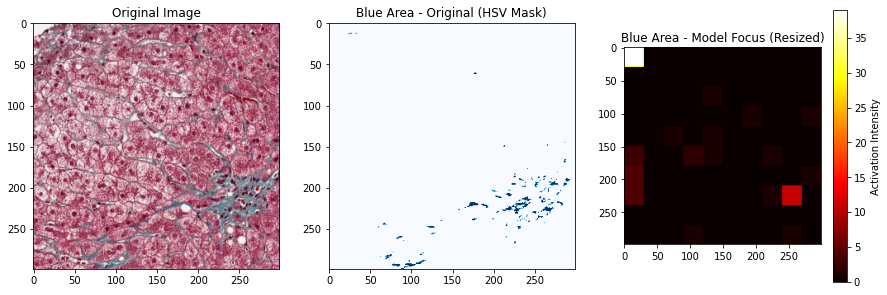

Blue Stain Area (Original Image - HSV): 843 pixels (0.94%)
Blue Stain Area (Model-Extracted - Yellow and White Regions): 4500 pixels (5.03%)
Predicted Fibrosis Score: 4


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
import cv2
from PIL import Image
import tensorflow as tf

# Load the fibrosis model
fibrosis_model = tf.keras.models.load_model("D:/PATENT/Model_testing/fibrosis_modified_model25.h5")

# Function to calculate the blue stain area in the original image using HSV
def calculate_blue_area_hsv(img_path):
    img = load_img(img_path, target_size=(299, 299))
    img_array = img_to_array(img)
    
    # Convert image to HSV color space to target blue hues
    hsv_img = cv2.cvtColor(img_array.astype('uint8'), cv2.COLOR_RGB2HSV)
    
    # Define blue color range in HSV space
    lower_blue = np.array([90, 50, 50])
    upper_blue = np.array([130, 255, 255])
    
    # Create a mask to extract blue regions
    mask = cv2.inRange(hsv_img, lower_blue, upper_blue)
    
    # Calculate blue area and its percentage
    blue_area = np.sum(mask > 0)
    total_area = mask.size
    blue_area_percentage = (blue_area / total_area) * 100
    
    return blue_area, blue_area_percentage, mask

# Function to generate feature maps from the fibrosis model
def generate_feature_map_fibrosis(img_path, model):
    img = load_img(img_path, target_size=(299, 299))
    img_array = img_to_array(img)
    
    # Apply proper preprocessing
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # Use ResNet50-specific preprocessing
    
    # Extract feature maps from a specific layer (last convolutional layer)
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('conv5_block3_out').output)
    feature_maps = intermediate_layer_model.predict(img_array)
    
    return feature_maps[0]

# Function to predict fibrosis score using the fibrosis model
def predict_fibrosis_score(img_path, model):
    img = load_img(img_path, target_size=(299, 299))
    img_array = img_to_array(img) / 255.0  # Normalize image
    img_array = np.expand_dims(img_array, axis=0)
    
    # Preprocess using ResNet50 preprocessing
    img_array = preprocess_input(img_array)
    
    # Predict fibrosis score
    preds = model.predict(img_array)
    predicted_score = np.argmax(preds)  # Returns a score between 0-4
    
    return predicted_score

# Function to calculate the blue stain area from model-extracted feature maps
def calculate_blue_area_from_feature_maps(feature_maps, predicted_score, original_size=(299, 299)):
    # Apply dynamic threshold based on predicted score
    if predicted_score == 0:
        threshold_value = 0.7  # Higher threshold for less activation
    elif predicted_score == 1:
        threshold_value = 0.5
    elif predicted_score == 2:
        threshold_value = 0.4
    elif predicted_score == 3:
        threshold_value = 0.3
    else:  # predicted_score == 4
        threshold_value = 0.2  # Lowest threshold for max activation
    
    # Apply threshold to focus on significant activations
    threshold = np.max(feature_maps) * threshold_value
    focus_mask = np.sum(feature_maps > threshold, axis=-1)
    
    # Resize the mask back to original image size
    focus_mask_resized = cv2.resize(focus_mask, original_size, interpolation=cv2.INTER_NEAREST)
    
    # Calculate the blue area of yellow and white regions only
    yellow_white_regions = (focus_mask_resized > (threshold * 0.5))  # Target significant activations
    blue_area_model = np.sum(yellow_white_regions)
    
    total_area = focus_mask_resized.size
    blue_area_percentage = (blue_area_model / total_area) * 100
    
    return blue_area_model, blue_area_percentage, focus_mask_resized

# Function to visualize the results with consistent scaling for plots
def visualize_blue_areas(original_image, original_mask, focus_mask_resized):
    plt.figure(figsize=(15, 5))
    
    # Plot the original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    
    # Plot the blue-stained area in the original image (HSV mask)
    plt.subplot(1, 3, 2)
    plt.imshow(original_mask, cmap='Blues')
    plt.title('Blue Area - Original (HSV Mask)')
    
    # Plot the model's focus regions (resized to match original image scale)
    plt.subplot(1, 3, 3)
    plt.imshow(focus_mask_resized, cmap='hot')
    plt.colorbar(label='Activation Intensity')
    plt.title('Blue Area - Model Focus (Resized)')
    
    plt.show()

# Example usage on a single image
img_path = "D:/PATENT/random_test_images/Fibrosis/f_1_47_102_24.jpg"

# Step 1: Calculate blue area from the original image using HSV filtering
blue_area_original, blue_area_percentage_original, blue_mask = calculate_blue_area_hsv(img_path)

# Step 2: Generate feature maps from the fibrosis model
feature_maps = generate_feature_map_fibrosis(img_path, fibrosis_model)

# Step 3: Predict fibrosis score using the fibrosis model
predicted_score = predict_fibrosis_score(img_path, fibrosis_model)

# Step 4: Calculate blue area from the model's focus regions (feature maps)
blue_area_model, blue_area_percentage_model, focus_mask_resized = calculate_blue_area_from_feature_maps(
    feature_maps, predicted_score)

# Step 5: Visualize the original image, original blue-stained area, and model focus area
visualize_blue_areas(load_img(img_path, target_size=(299, 299)), blue_mask, focus_mask_resized)

# Print the calculated areas in terms of percentage of total image area
print(f"Blue Stain Area (Original Image - HSV): {blue_area_original} pixels ({blue_area_percentage_original:.2f}%)")
print(f"Blue Stain Area (Model-Extracted - Yellow and White Regions): {blue_area_model} pixels ({blue_area_percentage_model:.2f}%)")
print(f"Predicted Fibrosis Score: {predicted_score}")
